In [2]:
import numpy as np
import hmmlearn
from hmmlearn.hmm import GaussianHMM
import joblib
import os
from os.path import join

In [210]:
import matplotlib.pyplot as plt

In [46]:
import pdb

In [27]:
from glob import glob

In [9]:
from joblib import Parallel, delayed

In [6]:
from scipy.linalg import sqrtm

In [31]:
birdpath = '/media/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets_ngf64'

In [32]:
day = 'day_20'
hidden_state = '100'

# load model

In [33]:
model = joblib.load(join(birdpath, day, 'hmm_hiddensize_'+hidden_state, 'model_'+day+'.pkl'))

In [34]:
model = model['model']

In [35]:
model.n_components

100

In [231]:
model2 = joblib.load(join(birdpath, day, 'hmm_hiddensize_60', 'model_'+day+'.pkl'))
model2 = model2['model']
model2.n_components

60

# get sequences

In [36]:
data_pkl_path = glob(join(birdpath, day, 'hmm_hiddensize_'+hidden_state, 'data_and_scores*'))[0]
data_pkl_path

'/media/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets_ngf64/day_20/hmm_hiddensize_100/data_and_scores_day_20.pkl'

In [37]:
data = joblib.load(data_pkl_path)
ztrain = data['ztrain']
ztest = data['ztest']

In [39]:
print(len(ztrain), len(ztest))

841 211


In [120]:
type(ztrain)

list

# least visited states

In [223]:
T = 1*model.transmat_
T.shape

(100, 100)

In [224]:
column_sums = T.sum(axis=0)

In [225]:
np.min(column_sums)

0.12146723951012253

<BarContainer object of 100 artists>

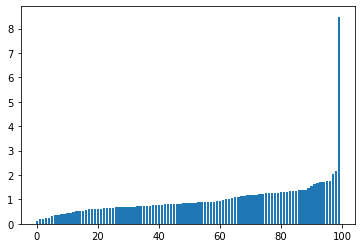

In [226]:
plt.bar(np.arange(T.shape[0]), sorted(column_sums))

# can we reduce the dimensionality of the hmm without losing likelihood points

In [207]:
new_model = reduce_model(model, ztrain, iters=10)

..... original logL = 186.471 .....


Fitting a model with 12176 free scalar parameters with only 12000 data points will result in a degenerate solution.


..... merged states 19 and 28 .....
..... new logL = 137.371 .....
..... merged states 0 and 98 .....
..... new logL = 110.724 .....
..... merged states 20 and 64 .....
..... new logL = 109.086 .....
..... merged states 7 and 68 .....
..... new logL = 107.605 .....
..... merged states 4 and 29 .....
..... new logL = 105.703 .....
..... merged states 67 and 79 .....
..... new logL = 102.558 .....
..... merged states 24 and 46 .....
..... new logL = 98.294 .....
..... merged states 55 and 67 .....
..... new logL = 90.887 .....
..... merged states 3 and 82 .....
..... new logL = 89.839 .....
..... merged states 53 and 83 .....
..... new logL = 55.276 .....


In [233]:
logL2 = get_normalized_scores(model2, ztest)
logL2

2.1157412806084714

In [228]:
new_model = reduce_model_by_dropstate(model, ztest, iters=30, prob_thresh=0.7)

Fitting a model with 12176 free scalar parameters with only 12000 data points will result in a degenerate solution.


..... original logL = 172.220 .....
..... dropped state 48 .....
..... new logL = 167.295 .....
..... dropped state 38 .....
..... new logL = 164.976 .....
..... dropped state 20 .....
..... new logL = 161.071 .....
..... dropped state 93 .....
..... new logL = 159.605 .....
..... dropped state 36 .....
..... new logL = 157.927 .....
..... dropped state 65 .....
..... new logL = 155.968 .....
..... dropped state 56 .....
..... new logL = 140.493 .....
..... dropped state 8 .....
..... new logL = 138.991 .....
..... dropped state 35 .....
..... new logL = 137.817 .....
..... dropped state 31 .....
..... new logL = 136.649 .....
..... dropped state 15 .....
..... new logL = 129.543 .....
..... dropped state 46 .....
..... new logL = 128.151 .....
..... dropped state 20 .....
..... new logL = 125.280 .....
..... dropped state 58 .....
..... new logL = 120.858 .....
..... dropped state 73 .....
..... new logL = 119.073 .....
..... dropped state 37 .....
..... new logL = 101.043 .....
.....

In [206]:
def reduce_model(model, data, iters=10):
    
    new_model = model
    
    logL = get_normalized_scores(new_model, data, False)
    print('..... original logL = %.3f .....'%(logL))
    
    for i in range(iters):
        
        # find wasserstein distance between all gaussians
        D, inds = distance_matrix(new_model)
        idx = np.argmin(D)
        i_j = list(inds[idx])
        
        new_model = merge_states(new_model, *i_j)
        print('..... merged states %d and %d .....'%(i_j[0], i_j[1]))
        
        logL = get_normalized_scores(new_model, data, False)
        print('..... new logL = %.3f .....'%(logL))
        
    return new_model

In [230]:
def reduce_model_by_dropstate(model, data, iters=10, prob_thresh=0.2):
    
    new_model = model
    
    logL = get_normalized_scores(new_model, data, False)
    print('..... original logL = %.3f .....'%(logL))
    
    for i in range(iters):
        
        # find least visited state
        T = new_model.transmat_.sum(axis=0)
        
        idx = np.argmin(T)
        print('...... prob=%.3f ......'%(T[idx]))
        if T[idx] > prob_thresh:
            print('...... probability threshold exceeded, stopping ......')
            break
            
        new_model = drop_state(new_model, idx)
        print('..... dropped state %d .....'%(idx))
        
        logL = get_normalized_scores(new_model, data, False)
        print('..... new logL = %.3f .....'%(logL))
        
    return new_model

In [205]:
def get_normalized_scores(model, seqs, normalize_by_length=True):
    """Normalized loglikelihood score"""
    LogL = 0.
    for n in range(len(seqs)):
        
        ll = model.score(seqs[n]) 
        
        if normalize_by_length:
            ll /= seqs[n].shape[0]
            
        LogL += ll
    return LogL / len(seqs)

In [83]:
def wasserstein(mu1, mu2, cov1, cov2):
    C2_sqrt = sqrtm(cov2)
    term1 = ((mu1-mu2)**2).sum()
    term2 = np.trace(cov1 + cov2 - (2 * sqrtm(C2_sqrt @ (cov1 @ C2_sqrt))))
    return term1 + term2

In [106]:
def distance_matrix(model):
    nstates = model.n_components
    
    D = []
    indices = []
    for i in range(nstates):
        for j in range(i+1, nstates):
            result = wasserstein(model.means_[i], model.means_[j], model.covars_[i], model.covars_[j]) 
            D.append(result)
            indices.append([i, j])
    return np.array(D), np.array(indices)

In [108]:
D, inds = distance_matrix(model)

In [101]:
D.shape

(4950,)

In [112]:
np.argmax(D)

4591

In [113]:
D[4591]

36.281121430045644

In [115]:
inds[np.argmin(D)]

array([19, 28])

In [143]:
%pdb

Automatic pdb calling has been turned ON


In [198]:
new_model = merge_states(model, 0,1)

Fitting a model with 12176 free scalar parameters with only 12000 data points will result in a degenerate solution.


In [199]:
new_model.startprob_.shape

(99,)

In [200]:
new_model.score(ztrain[0])

57.39297373395746

In [66]:
new_model.get_stationary_distribution().sum()

0.9999999999999999

In [67]:
model_a = merge_states()

100

In [204]:
# first the startprob
def merge_states(model, i, j):
    
    A = 1.*model.transmat_
    pi = 1. * model.startprob_
    p_merge = pi[i] + pi[j]
    pi = np.delete(pi, [i,j],axis=0)
    pi = np.append(pi, p_merge)
    
    # incoming paths to i and j
    p_merge = A[:,i] + A[:,j]
    p_merge = p_merge.reshape(-1,1)
    
    # remove original
    T = np.delete(A, [i,j], axis=1)
    # make new column
    T = np.concatenate([T, p_merge], axis=1)
    
    # outgoing paths from i and j
    p_i, p_j = T[i,:], T[j,:]  
    mix_prob = 0.5*(p_i + p_j)
    mix_prob = mix_prob.reshape(1,-1)
    T = np.delete(T, [i, j], axis=0)
    T = np.concatenate([T, mix_prob], axis=0)

    # now drop the means and covs
    means = 1.*model.means_
    covars = 1.*model.covars_
    if model.covariance_type == 'diag':
        covars = np.stack([np.diag(c) for c in covars])
        
    mu1 = means[i]
    mu2 = means[j]
    cov1 = covars[i]
    cov2 = covars[j]
        
    new_mu = 0.5*(mu1 + mu2)
    new_mu = new_mu.reshape(1,-1)
    new_cov = cov1 + cov2
    if model.covariance_type=='diag':
        new_cov = new_cov.reshape(1, -1)
    else:
        new_cov = new_cov.reshape(1, new_cov.shape[0], new_cov.shape[1])
    
    means = np.delete(means, [i,j], axis=0)
    covars = np.delete(covars, [i,j], axis=0)
    
    means = np.concatenate([means, new_mu],axis=0)
    covars = np.concatenate([covars, new_cov],axis=0)
    
    # new model
    new_model = GaussianHMM(n_components=model.n_components - 1,
                           covariance_type=model.covariance_type)
    # fit with random
    fake_init_data = np.random.multivariate_normal(mean=np.zeros(model.n_features),
                                                        cov=np.eye(model.n_features), 
                                                        size = 1000)
    new_model._init(fake_init_data)
    new_model.means_ = means
    new_model.covars_ = covars
    new_model.transmat_ = T
    new_model.startprob_ = np.array(pi)
    
    return new_model

In [220]:
def drop_state(model, i):
    '''
    This function drops the state "drop_state" from the start-probability and the transition matrix
    Then it redistributes the probability mass over the other entries
    '''
    A = 1.*model.transmat_
    pi = 1. * model.startprob_
    K = model.n_components
    
    # first the startprob
    p_drop = pi[i]
    # divide by number of remaining states
    p_add = p_drop / (K - 1)
    
    # add to remaining 
    pi = np.delete(pi, i)
    pi += p_add

    # now transition matrix
    # extract the mass from the drop_state column
    p_drop_column = A[:, i]
    # loop over rows (states)
    for k in range(K):
        if k != i:
            p_add = p_drop_column[k]/(K - 1)
            idss = np.arange(K)
            A[k, idss!=i] += p_add
            
    # drop the column
    A = np.delete(A, i, 1)
    
    # drop the row
    A = np.delete(A, i, 0)
    
    # now drop the means
    means = 1.*model.means_
    covars = 1.*model.covars_
    if model.covariance_type == 'diag':
        covars = np.stack([np.diag(c) for c in covars])
    
    means = np.delete(means, i, 0)
    # drop the covariances
    covars = np.delete(covars, i, 0)
    
    # reduce the number of states
    # new model
    new_model = GaussianHMM(n_components=model.n_components - 1,
                           covariance_type=model.covariance_type)
    # fit with random
    fake_init_data = np.random.multivariate_normal(mean=np.zeros(model.n_features),
                                                        cov=np.eye(model.n_features), 
                                                        size = 1000)
    new_model._init(fake_init_data)
    new_model.means_ = means
    new_model.covars_ = covars
    new_model.transmat_ = A
    new_model.startprob_ = pi
    
    return new_model

In [175]:
new_model = GaussianHMM(n_components=model.n_components,
                           covariance_type=model.covariance_type)

In [176]:
new_model._init(np.random.multivariate_normal(mean=np.zeros(model.n_features),
                                                        cov=np.eye(model.n_features), 
                                                        size = 100))

Fitting a model with 12399 free scalar parameters with only 1200 data points will result in a degenerate solution.


In [177]:
new_model.startprob_ = np.random.dirichlet(np.ones(100)/10)

In [178]:
new_model.startprob_.shape

(100,)

In [179]:
_, s = new_model.score(ztrain[0])

TypeError: cannot unpack non-iterable numpy.float64 object

> <ipython-input-179-4b3b98aba8aa>(1)<module>()
----> 1 _, s = new_model.score(ztrain[0])



ipdb>  q
